In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cpu


In [2]:
# Görseller için dönüşümler
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Dataset yolları
data_dir = "data"

train_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform
)

print("Toplam örnek sayısı:", len(train_dataset))
print("Sınıflar:", train_dataset.classes)



Toplam örnek sayısı: 80
Sınıflar: ['negative', 'positive']


In [3]:
from torch.utils.data import random_split

# %75 train, %25 test
train_size = int(0.75 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_ds, test_ds = random_split(
    train_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False)

print("Train örnek:", len(train_ds))
print("Test örnek:", len(test_ds))



Train örnek: 60
Test örnek: 20


In [4]:
# Daha hızlı olsun diye resnet18 kullanıyoruz (CPU'da mantıklı)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Feature extractor'ı dondur
for param in model.parameters():
    param.requires_grad = False

# Son katmanı 2 sınıf için değiştir
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

print("Model hazır:", type(model).__name__)


Model hazır: ResNet


In [5]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

epochs = 3
for epoch in range(epochs):
    loss, train_acc = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{epochs} | loss={loss:.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}")


Epoch 1/3 | loss=0.8424 | train_acc=0.367 | test_acc=0.500
Epoch 2/3 | loss=0.7043 | train_acc=0.583 | test_acc=0.500
Epoch 3/3 | loss=0.7190 | train_acc=0.517 | test_acc=0.450


In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

y_true = []
y_pred = []
y_score = []  # positive class olasılığı

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)                 # (batch, 2)
        probs = torch.softmax(outputs, dim=1)   # olasılıklar

        preds = probs.argmax(dim=1).cpu().numpy()
        pos_scores = probs[:, 1].cpu().numpy()  # class=1 (positive) skoru

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_score.extend(pos_scores)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

print("Test örnek:", len(y_true))


Test örnek: 20


In [7]:
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))


Confusion Matrix:
 [[6 3]
 [8 3]]

Classification Report:
               precision    recall  f1-score   support

           0      0.429     0.667     0.522         9
           1      0.500     0.273     0.353        11

    accuracy                          0.450        20
   macro avg      0.464     0.470     0.437        20
weighted avg      0.468     0.450     0.429        20



ROC-AUC: 0.3838383838383838


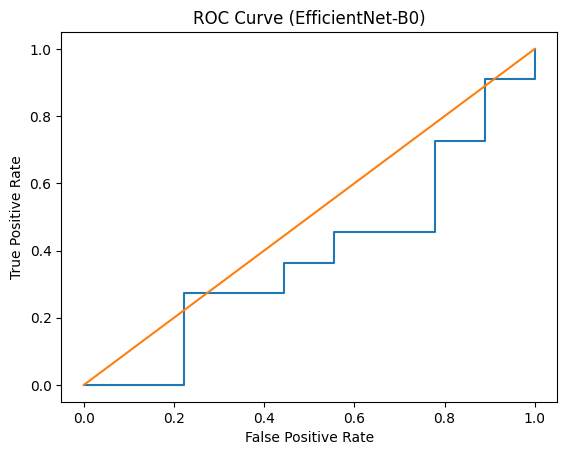

In [8]:
auc = roc_auc_score(y_true, y_score)
fpr, tpr, _ = roc_curve(y_true, y_score)

print("ROC-AUC:", auc)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (EfficientNet-B0)")
plt.show()


In [9]:
!pip install scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import sklearn
sklearn.__version__


'1.8.0'

In [11]:
!pip install matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


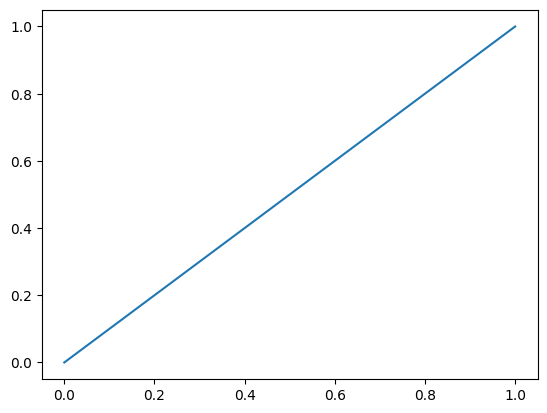

In [12]:
import matplotlib.pyplot as plt
plt.plot([0,1],[0,1])
plt.show()


In [14]:
print("class_to_idx:", train_dataset.class_to_idx)
print("1 - AUC:", 1 - auc)


class_to_idx: {'negative': 0, 'positive': 1}
1 - AUC: 0.6161616161616161


In [15]:
import os

def count_images(base_path):
    counts = {}
    total = 0
    for class_name in ["positive", "negative"]:
        class_path = os.path.join(base_path, class_name)
        if not os.path.exists(class_path):
            counts[class_name] = 0
            continue
        num_files = 0
        for root, dirs, files in os.walk(class_path):
            num_files += len([f for f in files if f.lower().endswith((".jpg", ".png", ".jpeg"))])
        counts[class_name] = num_files
        total += num_files
    return counts, total

# TRAIN
train_counts, train_total = count_images("data/train")
print("TRAIN SET:")
print(train_counts)
print("Toplam:", train_total)

# TEST
test_counts, test_total = count_images("data/test")
print("\nTEST SET:")
print(test_counts)
print("Toplam:", test_total)


TRAIN SET:
{'positive': 0, 'negative': 0}
Toplam: 0

TEST SET:
{'positive': 0, 'negative': 0}
Toplam: 0


In [16]:
import os

def count_images_flat(base_path):
    counts = {}
    total = 0
    for class_name in ["positive", "negative"]:
        class_path = os.path.join(base_path, class_name)
        num_files = 0
        for root, dirs, files in os.walk(class_path):
            num_files += len([f for f in files if f.lower().endswith((".jpg", ".png", ".jpeg"))])
        counts[class_name] = num_files
        total += num_files
    return counts, total

counts, total = count_images_flat("data")

print("DATASET GENEL DURUM:")
print(counts)
print("Toplam görsel:", total)


DATASET GENEL DURUM:
{'positive': 40, 'negative': 40}
Toplam görsel: 80


In [17]:
import os

def count_outfits(base_path):
    counts = {}
    total = 0
    for class_name in ["positive", "negative"]:
        class_path = os.path.join(base_path, class_name)
        if not os.path.exists(class_path):
            counts[class_name] = 0
            continue
        # her alt klasör = 1 kombin
        outfit_dirs = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]
        counts[class_name] = len(outfit_dirs)
        total += len(outfit_dirs)
    return counts, total

outfit_counts, outfit_total = count_outfits("data")
print("KOMBİN (ÖRNEK) SAYISI:")
print(outfit_counts)
print("Toplam kombin:", outfit_total)


KOMBİN (ÖRNEK) SAYISI:
{'positive': 20, 'negative': 20}
Toplam kombin: 40


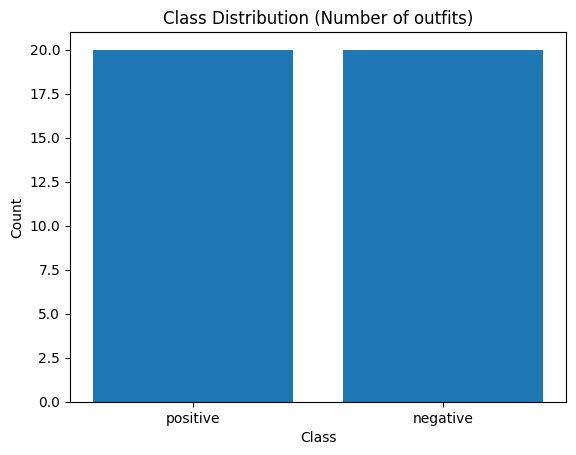

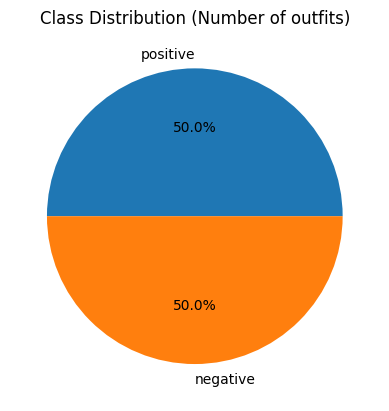

In [18]:
import matplotlib.pyplot as plt

labels = ["positive", "negative"]
values = [outfit_counts["positive"], outfit_counts["negative"]]

# Bar chart
plt.figure()
plt.bar(labels, values)
plt.title("Class Distribution (Number of outfits)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Pie chart
plt.figure()
plt.pie(values, labels=labels, autopct="%1.1f%%")
plt.title("Class Distribution (Number of outfits)")
plt.show()


In [19]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Train size: 80


NameError: name 'test_dataset' is not defined

In [20]:
# Notebook'ta şu an tanımlı değişkenleri filtreleyelim
[name for name in globals().keys() if "test" in name.lower()]


['test_size',
 'test_ds',
 'test_loader',
 'test_acc',
 'test_counts',
 'test_total']

In [21]:
print("Train size:", len(train_loader.dataset))
print("Test size:", len(test_loader.dataset))


Train size: 60
Test size: 20
